In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from graphviz import Source
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from mlxtend.classifier import StackingClassifier

from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

C:\Users\souro\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
wines_noise = pd.read_csv('../../NumericData/30_noisy_winequality.csv')

wines_noise['quality_label'] = wines_noise.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines_noise = wines_noise.sample(frac=1, random_state=101).reset_index(drop=True)

In [3]:
wines_original = pd.read_csv('../../NumericData/winequality.csv')

wines_original['quality_label'] = wines_original.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines_original = wines_original.sample(frac=1, random_state=101).reset_index(drop=True)

In [4]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [5]:
details = rstr(wines_noise, 'quality')
details.sort_values(by='missing_ration', ascending=False)

Data shape: (6497, 14)
___________________________
Data types:
 float64    11
object      2
int64       1
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing_ration  \
pH                    float64    6492        131      5        0.076959   
fixed acidity         float64    6493       1107      4        0.061567   
volatile acidity      float64    6493        224      4        0.061567   
sulphates             float64    6493        180      4        0.061567   
citric acid           float64    6495        168      2        0.030783   
residual sugar        float64    6496       2539      1        0.015392   
chlorides             float64    6496        216      1        0.015392   
type                   object    6497          2      0        0.000000   
free sulfur dioxide   float64    6497       2880      0        0.000000   
total sulfur dioxide  float64    6497       3095      0        0.000000   
density               float64    6497        847      0        0.000000   
alcohol               float64    6497        694      0        0.000000   
quality                 int64    6497          7      0        0.000000   
quality_label          object    6497          3      0        0.000000   

                                                                uniques  \
pH                    [[3.28, 2.77, 3.89, 3.09, 3.32, 2.95, 3.23, 3....   
fixed acidity         [[6.95, 6.9, 9.5, 10.98, 7.9, 9.8, 7.0, 4.21, ...   
volatile acidity      [[0.28, 1.46, 0.46, 0.27, 1.0, 0.34, 0.13, 1.3...   
sulphates             [[0.82, 0.43, 1.24, 0.68, 1.33, 0.55, 1.27, 0....   
citric acid           [[0.42, 1.21, 0.62, 0.4, 1.64, 1.56, 0.37, 0.1...   
residual sugar        [[14.4, 31.57, 2.7, 2.2, 4.9, 1.4, 12.85, 51.5...   
chlorides             [[0.04, 0.07, 0.15, 0.057999999999999996, 0.03...   
type                                                     [[white, red]]   
free sulfur dioxide   [[49.0, 12.0, 181.39, 6.0, 31.0, 143.11, 36.0,...   
total sulfur dioxide  [[173.0, 372.41, 426.18, 78.98, 79.87, 328.0, ...   
density               [[1.03, 0.9948, 0.998, 1.02, 0.9966, 0.9947, 1...   
alcohol               [[9.0, 11.4, 10.0, 12.2, 9.7, 10.7, 9.5, 10.4,...   
quality                                         [[7, 4, 6, 5, 8, 3, 9]]   
quality_label                                     [[medium, low, high]]   

                      skewness  kurtosis  corr quality  
pH                    0.564044 -0.158514      0.001624  
fixed acidity         1.000293  0.061482     -0.010148  
volatile acidity      1.053240 -0.047584     -0.046404  
sulphates             1.148262  0.135930      0.014201  
citric acid           1.099097  0.117370      0.018022  
residual sugar        1.067621 -0.195122     -0.001659  
chlorides             1.125545 -0.179943     -0.019030  
type                       NaN       NaN           NaN  
free sulfur dioxide   1.134971 -0.049880      0.008746  
total sulfur dioxide  0.814269 -0.060547     -0.006547  
density               1.245572  0.328630     -0.037419  
alcohol               0.503555 -0.635600      0.190983  
quality               0.189623  0.232322      1.000000  
quality_label              NaN       NaN           NaN

In [6]:
wines_noise.quality_label.value_counts()


medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [7]:
wines_noise.dropna().quality_label.value_counts()


medium    3903
low       2378
high       198
Name: quality_label, dtype: int64

In [8]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines_noise = DataFrameImputer().fit_transform(wines_noise)
wines_noise.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white           6.95              0.28         0.42           14.40   
1    red           6.90              1.46         1.21           31.57   
2    red           9.50              0.46         0.62            2.70   
3    red          10.98              0.27         0.40            2.20   
4  white           7.90              1.00         1.64            4.90   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.040                49.00                173.00   1.0300  3.28   
1      0.070                12.00                372.41   0.9948  2.77   
2      0.150               181.39                426.18   0.9980  3.89   
3      0.058                 6.00                 78.98   1.0200  3.09   
4      0.030                31.00                 79.87   0.9966  3.32   

   sulphates  alcohol  quality quality_label  
0       0.82      9.0        7        medium  
1       0.43     11.4        4           low  
2       1.24     10.0        6        medium  
3       0.68     12.2        7        medium  
4       1.33      9.7        6        medium

In [9]:
wines_original.quality_label.value_counts()


medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [10]:
wines_original.dropna().quality_label.value_counts()


medium    3894
low       2372
high       197
Name: quality_label, dtype: int64

In [11]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines_original = DataFrameImputer().fit_transform(wines_original)
wines_original.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.3              0.28         0.42            14.4   
1    red            6.9              1.09         0.06             2.1   
2    red            9.5              0.46         0.24             2.7   
3    red            8.2              0.31         0.40             2.2   
4  white            7.9              0.28         0.41             4.9   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.040                 49.0                 173.0  0.99940  3.28   
1      0.061                 12.0                  31.0  0.99480  3.51   
2      0.092                 14.0                  44.0  0.99800  3.12   
3      0.058                  6.0                  10.0  0.99536  3.31   
4      0.058                 31.0                 153.0  0.99660  3.27   

   sulphates  alcohol  quality quality_label  
0       0.82      9.0        7        medium  
1       0.43     11.4        4           low  
2       0.74     10.0        6        medium  
3       0.68     11.2        7        medium  
4       0.51      9.7        6        medium

In [12]:
#Descriptive Statistics_ByType
subset_attributes = wines_noise.columns
rs = round(wines_noise.loc[wines_noise.type == 'red', subset_attributes].describe(),2)
ws = round(wines_noise.loc[wines_noise.type == 'white', subset_attributes].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                       \
                                   count    mean     std   min    25%     50%   
fixed acidity                     2350.0    8.57    2.81  3.81   6.60    7.68   
volatile acidity                  2350.0    0.58    0.38  0.08   0.28    0.47   
citric acid                       2350.0    0.53    0.44  0.00   0.23    0.38   
residual sugar                    2350.0   17.46   19.59  0.64   2.20    7.30   
chlorides                         2350.0    0.18    0.18  0.01   0.05    0.08   
free sulfur dioxide               2350.0   80.28   83.17  1.42  17.48   40.00   
total sulfur dioxide              2350.0  153.34  116.42  6.00  56.00  128.05   
density                           2350.0    1.00    0.01  0.99   0.99    1.00   
pH                                2350.0    3.29    0.28  2.72   3.11    3.26   
sulphates                         2350.0    0.81    0.45  0.22   0.50    0.63   
alcohol                           2350.0   10.93    1.67  8.00   9.50   10.64   
quality                           2350.0    5.75    0.87  3.00   5.00    6.00   

                                     White Wine Statistics                 \
                         75%     max                 count    mean    std   
fixed acidity          10.20   15.90                4147.0    8.33   2.87   
volatile acidity        0.77    1.58                4147.0    0.54   0.41   
citric acid             0.76    1.65                4147.0    0.56   0.42   
residual sugar         29.54   65.67                4147.0   18.28  18.77   
chlorides               0.29    0.61                4147.0    0.17   0.18   
free sulfur dioxide   131.50  288.49                4147.0   83.94  79.55   
total sulfur dioxide  219.99  438.54                4147.0  168.13  99.75   
density                 1.01    1.04                4147.0    1.00   0.01   
pH                      3.45    4.01                4147.0    3.28   0.29   
sulphates               1.03    2.00                4147.0    0.78   0.46   
alcohol                12.03   14.89                4147.0   10.94   1.69   
quality                 6.00    8.00                4147.0    5.86   0.87   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.81    6.40    7.30    9.59   15.89  
volatile acidity      0.08    0.24    0.35    0.77    1.58  
citric acid           0.00    0.28    0.38    0.74    1.66  
residual sugar        0.60    2.90   10.40   30.17   65.69  
chlorides             0.01    0.04    0.06    0.28    0.61  
free sulfur dioxide   1.00   27.00   47.00  128.67  288.49  
total sulfur dioxide  6.00  101.00  146.81  210.53  440.00  
density               0.99    0.99    1.00    1.01    1.04  
pH                    2.72    3.08    3.23    3.43    4.01  
sulphates             0.22    0.45    0.57    1.01    2.00  
alcohol               8.01    9.50   10.70   12.20   14.90  
quality               3.00    5.00    6.00    6.00    9.00

In [13]:
#Descriptive Statistics_ByQuality
#subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines_noise[wines_noise['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines_noise[wines_noise['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines_noise[wines_noise['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T

Low Quality Wine                                       \
                                count    mean     std   min    25%     50%   
fixed acidity                  2384.0    8.41    2.77  3.81   6.60    7.50   
volatile acidity               2384.0    0.58    0.39  0.08   0.28    0.44   
citric acid                    2384.0    0.54    0.43  0.00   0.24    0.38   
residual sugar                 2384.0   18.06   19.00  0.60   2.40    9.82   
chlorides                      2384.0    0.17    0.17  0.01   0.05    0.08   
free sulfur dioxide            2384.0   82.00   81.09  1.58  20.00   45.58   
total sulfur dioxide           2384.0  163.54  106.95  6.00  82.56  147.98   
density                        2384.0    1.00    0.01  0.99   0.99    1.00   
pH                             2384.0    3.28    0.29  2.72   3.09    3.23   
sulphates                      2384.0    0.78    0.46  0.22   0.46    0.58   
alcohol                        2384.0   10.54    1.67  8.00   9.30   10.00   
quality                        2384.0    4.88    0.36  3.00   5.00    5.00   

                                     Medium Quality Wine           ...    \
                         75%     max               count    mean   ...     
fixed acidity           9.70   15.90              3915.0    8.43   ...     
volatile acidity        0.77    1.58              3915.0    0.54   ...     
citric acid             0.74    1.66              3915.0    0.55   ...     
residual sugar         29.51   65.57              3915.0   17.96   ...     
chlorides               0.28    0.61              3915.0    0.17   ...     
free sulfur dioxide   131.82  288.49              3915.0   82.99   ...     
total sulfur dioxide  216.07  440.00              3915.0  162.38   ...     
density                 1.01    1.04              3915.0    1.00   ...     
pH                      3.44    4.01              3915.0    3.29   ...     
sulphates               1.01    2.00              3915.0    0.79   ...     
alcohol                11.41   14.89              3915.0   11.15   ...     
quality                 5.00    5.00              3915.0    6.28   ...     

                                     High Quality Wine                        \
                         75%     max             count    mean     std   min   
fixed acidity          10.07   15.89             198.0    8.23    2.71  4.06   
volatile acidity        0.77    1.58             198.0    0.52    0.39  0.09   
citric acid             0.75    1.66             198.0    0.56    0.40  0.01   
residual sugar         30.40   65.69             198.0   17.36   17.59  0.80   
chlorides               0.29    0.61             198.0    0.16    0.18  0.01   
free sulfur dioxide   129.68  288.44             198.0   82.86   78.45  5.00   
total sulfur dioxide  212.00  439.60             198.0  161.49  105.07  6.79   
density                 1.01    1.04             198.0    1.00    0.01  0.99   
pH                      3.43    4.01             198.0    3.29    0.28  2.73   
sulphates               1.01    2.00             198.0    0.84    0.50  0.25   
alcohol                12.30   14.90             198.0   11.48    1.69  8.07   
quality                 7.00    7.00             198.0    8.03    0.16  8.00   

                                                     
                        25%     50%     75%     max  
fixed acidity          6.43    7.30    9.86   15.44  
volatile acidity       0.24    0.36    0.66    1.58  
citric acid            0.30    0.37    0.74    1.64  
residual sugar         3.92   10.84   27.49   65.45  
chlorides              0.03    0.06    0.24    0.61  
free sulfur dioxide   31.00   45.00  109.18  288.25  
total sulfur dioxide  96.00  128.00  187.50  437.49  
density                0.99    0.99    1.01    1.04  
pH                     3.13    3.25    3.43    4.01  
sulphates              0.46    0.62    1.14    1.98  
alcohol               10.34   11.78   12.60   14.85  
quality                8.00    8.00    8

In [14]:
# re-shuffle records just to randomize data points
wines_noise = wines_noise.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines_noise.type.values) # 1 - White; 0 - Red
wines_noise['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines_noise.quality_label.map(class_ql)

In [15]:
# re-shuffle records just to randomize data points
wines_original = wines_original.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines_original.type.values) # 1 - White; 0 - Red
wines_original['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines_original.quality_label.map(class_ql)

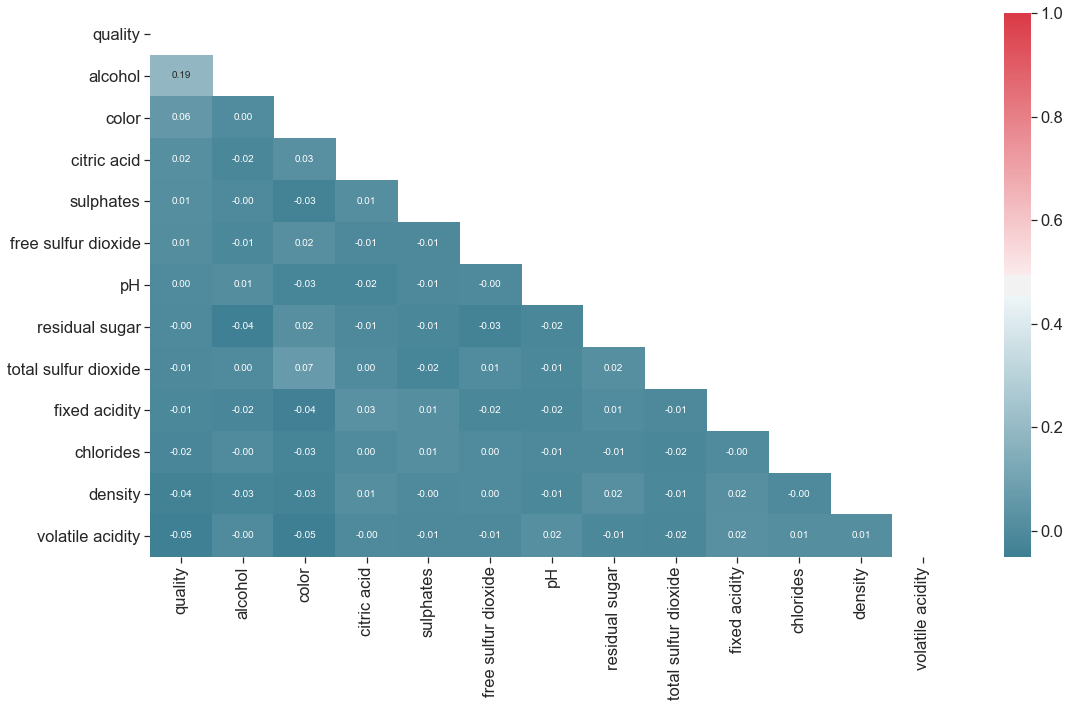

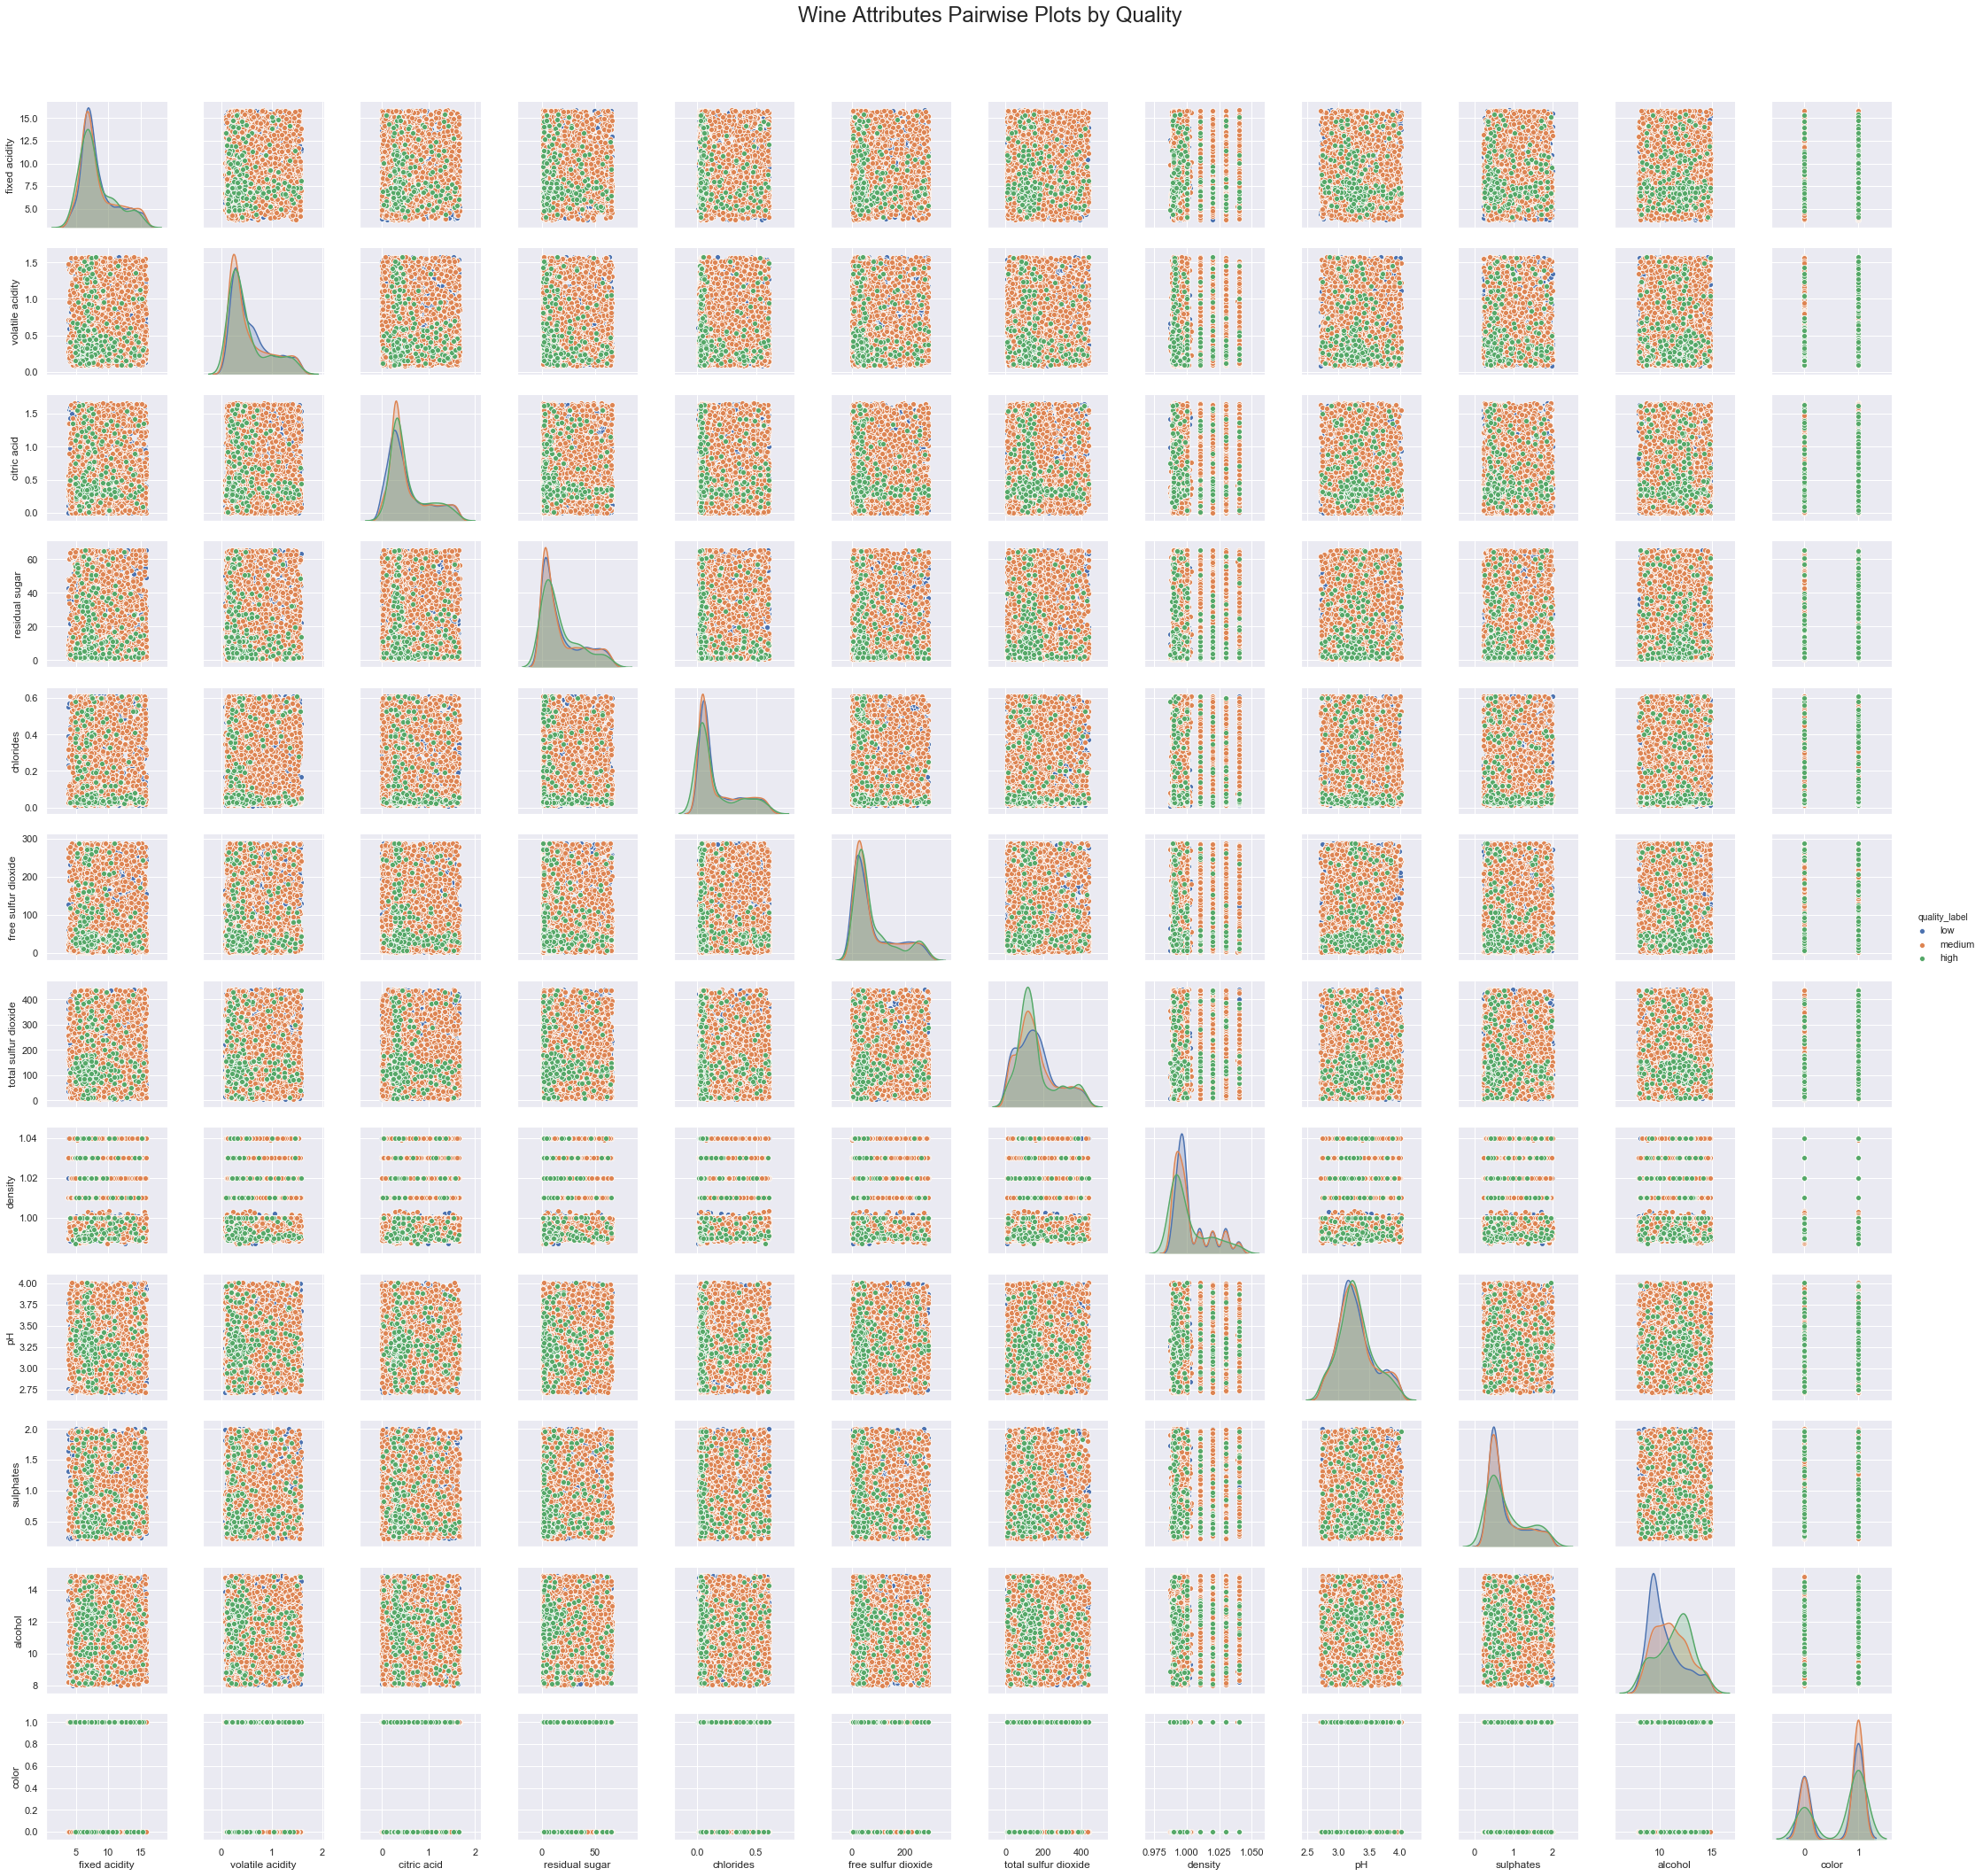

In [16]:
corr = wines_noise.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines_noise.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines_noise.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t


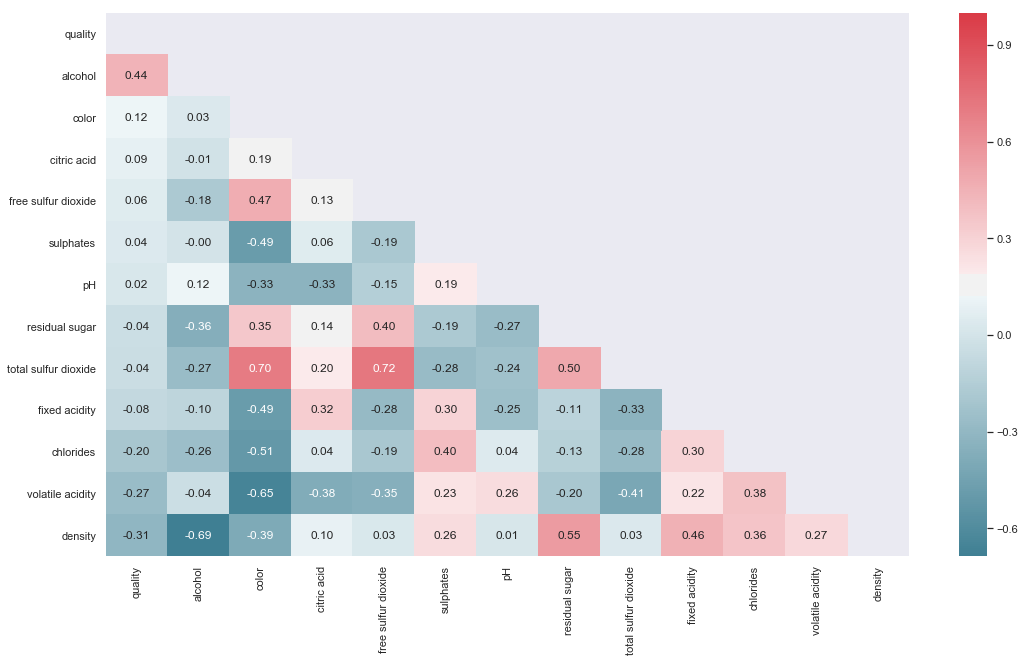

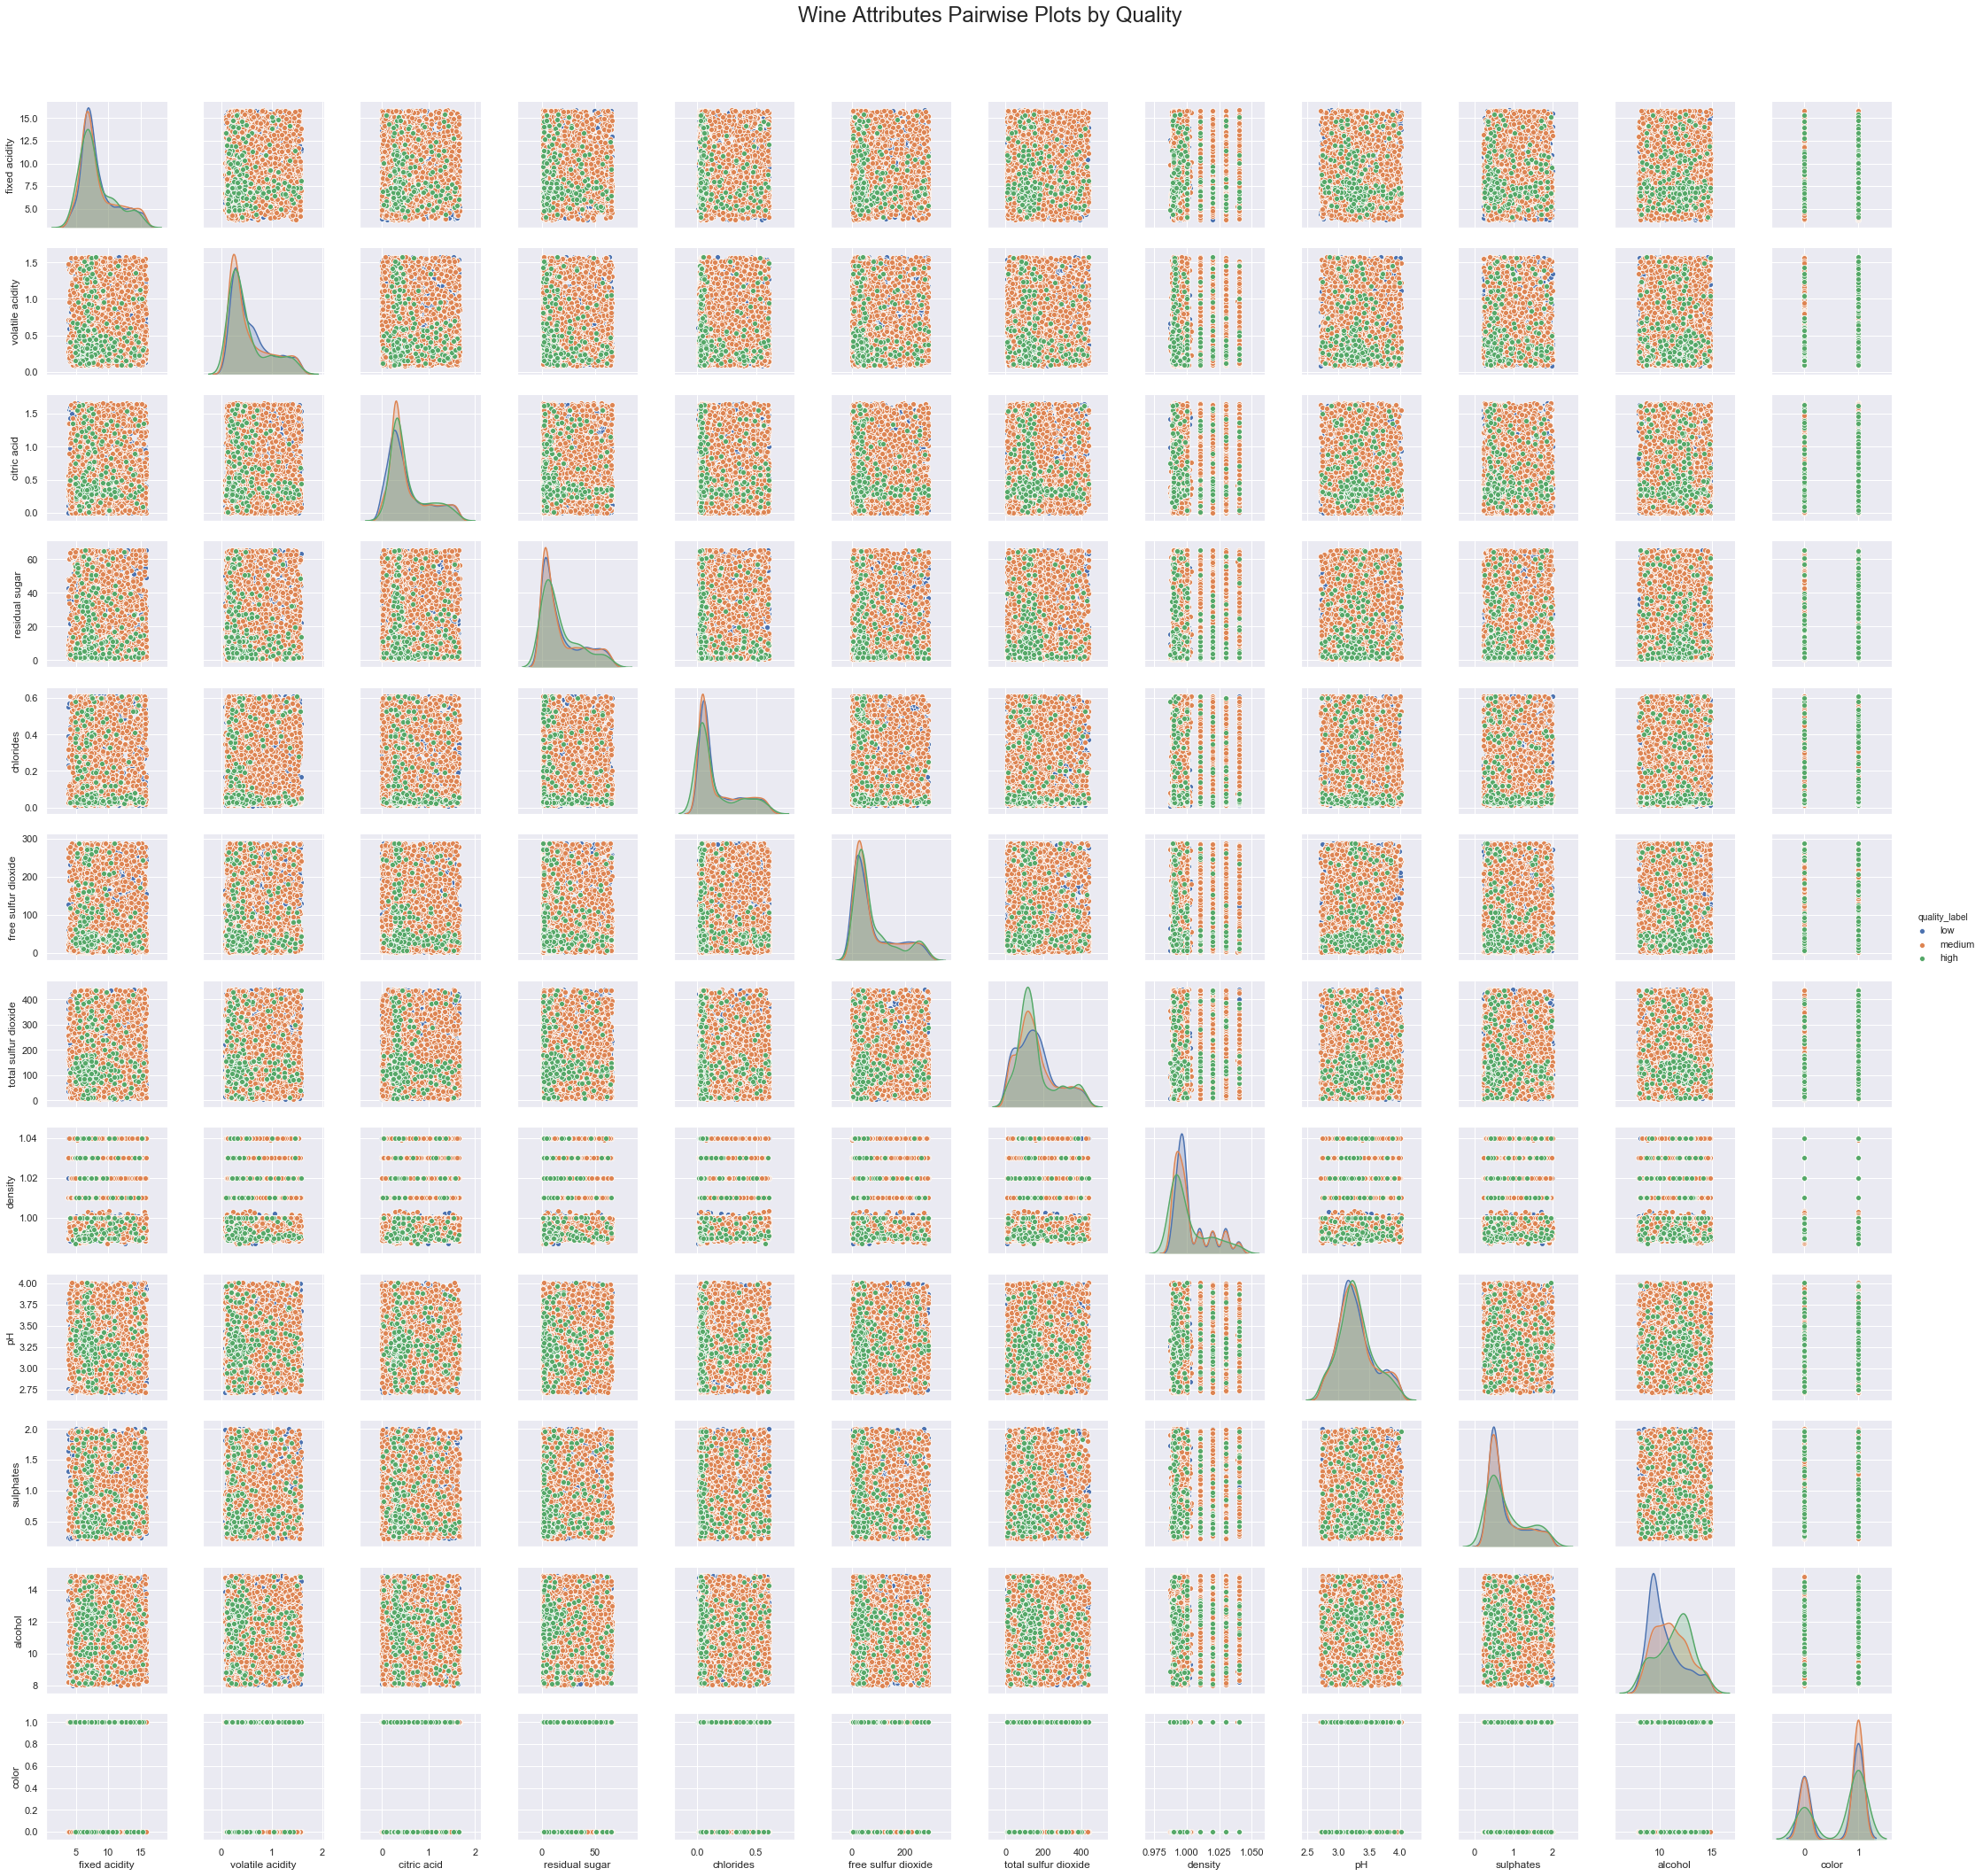

In [17]:
corr = wines_original.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines_original.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines_noise.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t


In [18]:
numeric_features = list(wines_noise.dtypes[(wines_noise.dtypes != "str") & (wines_noise.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines_noise[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines_noise[feat], l_opt[feat] = boxcox((wines_noise[feat]+1))

skewed_features2 = wines_noise[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 9 higest skewed numerical features to box cox transform


Skew  New Skew
density               1.245285  0.943369
sulphates             1.148350  0.207501
free sulfur dioxide   1.134709 -0.014859
chlorides             1.125372  0.503112
citric acid           1.099012  0.105297
residual sugar        1.067457  0.029233
volatile acidity      1.053321  0.208476
fixed acidity         1.000370  0.036077
total sulfur dioxide  0.814081 -0.056624

In [19]:
wines_noise.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0    red       0.993210          0.409647     0.133093        2.053929   
1    red       1.080056          0.360521     0.441652        3.565807   
2    red       1.065292          0.219701     0.509225        2.373661   
3    red       1.089536          0.387594     0.264357        1.970667   
4  white       1.043714          0.146159     0.195382        1.095298   

   chlorides  free sulfur dioxide  total sulfur dioxide   density    pH  \
0   0.037886             4.334144             19.704019  0.021426  3.88   
1   0.074851             3.145327             25.759755  0.021426  3.88   
2   0.047735             2.452901             28.121309  0.021426  2.94   
3   0.040796             2.621792             23.040298  0.021426  2.99   
4   0.034136             2.333833             16.928302  0.021426  3.05   

   sulphates  alcohol  quality quality_label  color  
0   0.242369    12.64        5           low      0  
1   0.298160     9.11        4           low      0  
2   0.278427    14.16        5           low      0  
3   0.239137    14.42        6        medium      0  
4   0.316326    13.29        5           low      1

In [20]:
numeric_features = list(wines_original.dtypes[(wines_original.dtypes != "str") & (wines_original.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines_original[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines_noise[feat], l_opt[feat] = boxcox((wines_original[feat]+1))

skewed_features2 = wines_original[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 6 higest skewed numerical features to box cox transform


Skew  New Skew
chlorides            5.399433  5.399433
sulphates            1.798605  1.798605
fixed acidity        1.723733  1.723733
volatile acidity     1.496087  1.496087
residual sugar       1.434889  1.434889
free sulfur dioxide  1.219784  1.219784

In [21]:
wines_original.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            5.9             0.290         0.16             7.9   
1    red           10.1             0.935         0.22             3.4   
2    red            9.1             0.340         0.42             1.8   
3  white            5.4             0.185         0.19             7.1   
4  white            7.9             0.190         0.26             2.1   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.044                 48.0                 197.0  0.99512  3.21   
1      0.105                 11.0                  86.0  1.00100  3.43   
2      0.058                  9.0                  18.0  0.99392  3.18   
3      0.048                 36.0                 110.0  0.99438  3.26   
4      0.039                  8.0                 143.0  0.99420  3.05   

   sulphates  alcohol  quality quality_label  color  
0       0.36      9.4        5           low      1  
1       0.64     11.3        4           low      0  
2       0.55     11.4        5           low      0  
3       0.41      9.5        6        medium      1  
4       0.74      9.8        5           low      1

In [22]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines_noise.columns.str.replace(' ', '_')
df = wines_noise.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)


VIF Factor              features
0     1.000000             Intercept
8     1.022228               density
9     1.025616                    pH
3     1.034338           citric_acid
11    1.051608               alcohol
7     1.114009  total_sulfur_dioxide
12    1.190047                 color
4     1.238934        residual_sugar
10    1.239734             sulphates
1     1.273630         fixed_acidity
2     1.414845      volatile_acidity
6     1.522019   free_sulfur_dioxide
5     1.600134             chlorides

In [23]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines_original.columns.str.replace(' ', '_')
df = wines_original.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)


VIF Factor              features
0     1.000000             Intercept
10    1.553300             sulphates
3     1.620286           citric_acid
5     1.658053             chlorides
2     2.164411      volatile_acidity
6     2.236447   free_sulfur_dioxide
9     2.544397                    pH
7     4.044881  total_sulfur_dioxide
1     5.008898         fixed_acidity
11    5.586239               alcohol
12    7.219469                 color
4     9.586359        residual_sugar
8    22.207092               density

In [24]:
cols = wines_noise.columns.str.replace(' ', '_')
df = wines_noise.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

VIF Factor             features
0     1.000000            Intercept
6     1.013661              density
7     1.022771                   pH
3     1.034182          citric_acid
9     1.043620              alcohol
10    1.185120                color
8     1.227993            sulphates
5     1.253458  free_sulfur_dioxide
1     1.267186        fixed_acidity
2     1.405597     volatile_acidity
4     1.598560            chlorides

In [25]:
cols = wines_original.columns.str.replace(' ', '_')
df = wines_original.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

VIF Factor             features
0     1.000000            Intercept
5     1.445440  free_sulfur_dioxide
8     1.456303            sulphates
3     1.603759          citric_acid
7     1.611557                   pH
4     1.630363            chlorides
2     2.084068     volatile_acidity
1     2.528013        fixed_acidity
9     2.572116              alcohol
6     3.367309              density
10    3.715577                color

In [26]:
wines_original.head()


type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            5.9             0.290         0.16             7.9   
1    red           10.1             0.935         0.22             3.4   
2    red            9.1             0.340         0.42             1.8   
3  white            5.4             0.185         0.19             7.1   
4  white            7.9             0.190         0.26             2.1   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.044                 48.0                 197.0  0.99512  3.21   
1      0.105                 11.0                  86.0  1.00100  3.43   
2      0.058                  9.0                  18.0  0.99392  3.18   
3      0.048                 36.0                 110.0  0.99438  3.26   
4      0.039                  8.0                 143.0  0.99420  3.05   

   sulphates  alcohol  quality quality_label  color  
0       0.36      9.4        5           low      1  
1       0.64     11.3        4           low      0  
2       0.55     11.4        5           low      0  
3       0.41      9.5        6        medium      1  
4       0.74      9.8        5           low      1

In [27]:
wines_noise.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0    red       0.585237          0.160994     0.133093        1.419711   
1    red       0.599249          0.235665     0.441652        1.097168   
2    red       0.597260          0.173996     0.509225        0.832692   
3    red       0.581843          0.123911     0.264357        1.382007   
4  white       0.594065          0.126056     0.195382        0.896790   

   chlorides  free sulfur dioxide  total sulfur dioxide   density    pH  \
0   0.027194            10.219669             19.704019  0.021426  3.88   
1   0.038760             4.482891             25.759755  0.021426  3.88   
2   0.031399             3.965127             28.121309  0.021426  2.94   
3   0.028537             8.777457             23.040298  0.021426  2.99   
4   0.025330             3.684154             16.928302  0.021426  3.05   

   sulphates  alcohol  quality quality_label  color  
0   0.198550    12.64        5           low      0  
1   0.253576     9.11        4           low      0  
2   0.240189    14.16        5           low      0  
3   0.211772    14.42        6        medium      0  
4   0.265321    13.29        5           low      1

In [28]:
loop = 150
randval = [0]

In [29]:
wqp_class_labels = np.array(wines_noise['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines_noise.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(wines_noise.loc[:, cols], y_ql.values, test_size=0.20, random_state=0)

In [30]:
X_train_noise.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
5372       0.599422          0.178558     0.118982        1.031510   0.040019   
1790       0.592370          0.169085     0.321418        1.651702   0.030878   
5879       0.591614          0.166489     0.268636        1.448937   0.030051   
1065       0.592370          0.160994     0.255566        0.809103   0.032372   
852        0.586421          0.178558     0.200943        0.896790   0.023673   

      free sulfur dioxide  total sulfur dioxide   density    pH  sulphates  \
5372             4.230657              9.103823  0.021426  3.23   0.256159   
1790            10.761080             14.039029  0.021426  3.29   0.244999   
5879             5.388347             18.311018  0.021426  3.29   0.253576   
1065             3.965127              7.723777  0.021426  3.75   0.236764   
852              5.594079             16.863115  0.021426  3.40   0.262090   

      alcohol  color  
5372     12.0      0  
1790      8.7      0  
5879      9.9      1  
1065      9.5      0  
852      11.5      1

In [31]:
wqp_class_labels = np.array(wines_original['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines_original.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(wines_original.loc[:, cols], y_ql.values, test_size=0.20, random_state=0)

In [32]:
X_train_original.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
5372           10.2              0.36         0.64             2.9      0.122   
1790            7.4              0.32         0.55            16.6      0.056   
5879            7.2              0.31         0.41             8.6      0.053   
1065            7.4              0.29         0.38             1.7      0.062   
852             6.1              0.36         0.27             2.1      0.035   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
5372                 10.0                  41.0   0.9980  3.23       0.66   
1790                 53.0                 238.0   1.0017  2.96       0.58   
5879                 15.0                  89.0   0.9976  3.29       0.64   
1065                  9.0                  30.0   0.9968  3.41       0.53   
852                  16.0                 100.0   0.9917  3.40       0.71   

      alcohol  color  
5372     12.5      0  
1790      8.7      1  
5879      9.9      1  
1065      9.5      0  
852      11.5      1

In [33]:
#Modelling with Noisy Training Data and Clean Test data

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_noise, y_train_noise)
y_pred = model.predict(X_test_original)

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cm = confusion_matrix(y_test_original, y_pred)
print(cm)
print(accuracy_score(y_test_original, y_pred))
print(f1_score(y_test_original, y_pred,average='weighted'))

[[457   0   0]
 [805   0   0]
 [ 38   0   0]]
0.351538461538
0.18287202837


In [ ]:
# importing Random Forest function
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_noise, y_train_noise)
y_pred = model.predict(X_test_original)

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cm = confusion_matrix(y_test_original[i], y_pred[i])
print(cm)
print(accuracy_score(y_test_original, y_pred))
print(f1_score(y_test_original, y_pred,average='weighted'))

Mean Accuracy is : 0.476923076923
Mean F1 is : 0.432596155901


In [52]:
from sklearn.svm import SVC

y_pred = []
for i in range(0,len(X_train_noise)):
    #model.fit(X_train_noise[i], y_train_noise[i].ravel())
    #y_predi = model.predict(X_test_original[i])
    classifier = SVC(random_state=0, kernel='rbf',probability=True)
    classifier.fit(X_train_noise[i], y_train_noise[i].ravel())
    y_predi = classifier.predict(X_test_original[i])
    y_pred.append(y_predi)

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
accuracy = []
f1 = []
for i in range(0,len(X_train_noise)):
    cm = confusion_matrix(y_test_original[i], y_pred[i])
    #print(cm)
    #print(accuracy_score(y_test_original[i], y_pred[i]))
    #print(f1_score(y_test_original[i], y_pred[i],average='weighted'))
    accuracy.append(accuracy_score(y_test_original[i], y_pred[i]))
    f1.append(f1_score(y_test_original[i], y_pred[i],average='weighted'))

print("Mean Accuracy is : "+str(np.mean(accuracy)))
print("Mean F1 is : "+str(np.mean(f1)))

Mean Accuracy is : 0.354615384615
Mean F1 is : 0.18941272547
